In [3]:
from src import *

## Description

Order the films and rests for an averaged gradients over participants to then order the films and rests videos in some manifold.

GOAL: Ordering metric and observing the relative positions of movies/rest

## Table of Contents

- [All Video Processing](#all)
    - Functional Connectivity Matrix and Gradient Computation
    - Joint Plot 1st and 2nd Gradient
    - Visualization of Gradients on Cortical Surfaces

- [Ordering of Videos](#order)
    - Distance definition 
    - Order of films and observations

In [87]:
mri_path = "./data/fmri_compiled/"
print(os.listdir(mri_path))

movie_name   = os.listdir(mri_path)[14]
nmovie       = movie_name.split('_')[0]
mri_df       = pd.read_csv(mri_path + movie_name)
# mri_df2      = pd.read_csv(mri_path + "Rest_compiled.csv")

['TheSecretNumber_compiled.csv', 'ToClaireFromSonny_compiled.csv', 'Chatter_compiled.csv', 'LessonLearned_compiled.csv', 'Payload_compiled.csv', 'AfterTheRain_compiled.csv', 'Superhero_compiled.csv', 'Sintel_compiled.csv', 'TearsOfSteel_compiled.csv', 'BetweenViewing_compiled.csv', 'BigBuckBunny_compiled.csv', 'Rest_compiled.csv', 'YouAgain_compiled.csv', 'Spaceman_compiled.csv', 'FirstBite_compiled.csv']


<a class="anchor" id="all"></a>
### Group Level

#### NOTE: Group level gradients for each films were aligned to rest gradients group level

Joint Plot of 1st and 2nd Gradient

In [93]:
path  = './resources/static_grad/group_level/'
grads = []
labels = []
for mov in os.listdir(path):
    grads.append(load(path + mov))
    labels.append(mov.split('_')[0])

In [99]:
aligned = procrustes_alignment(grads, reference= grads[2], n_iter=100)

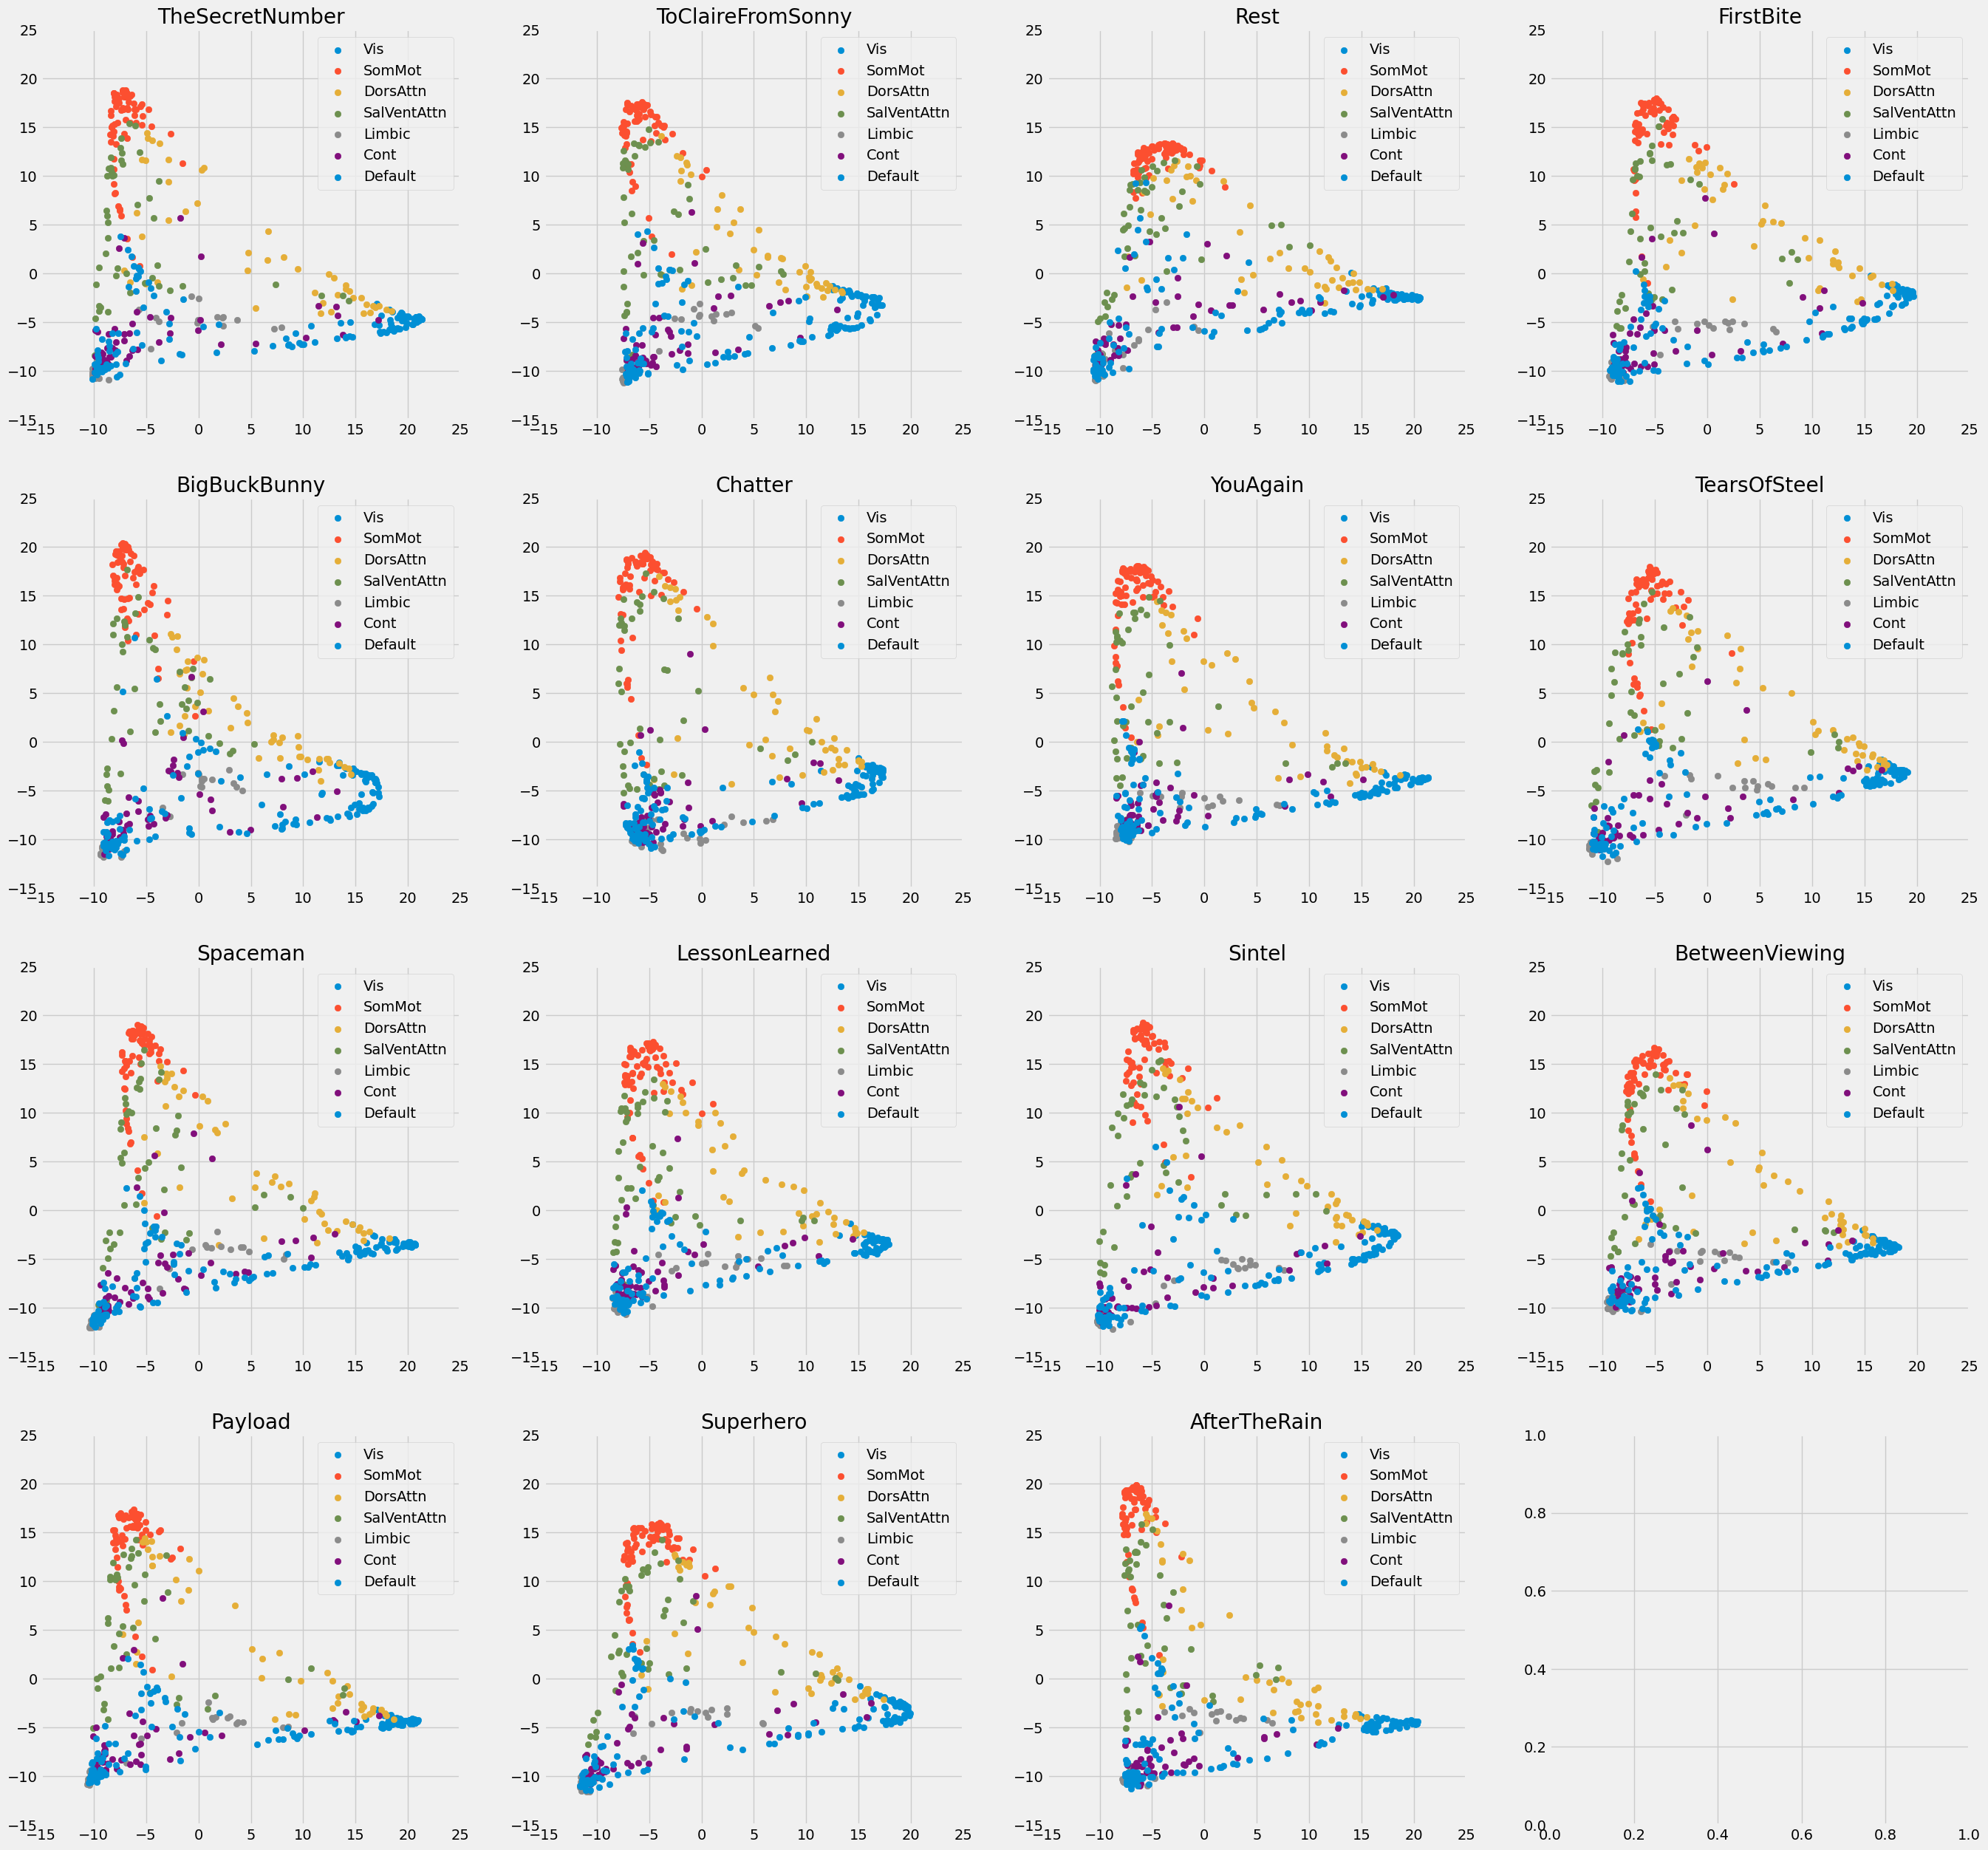

In [102]:
partial_region = load('./resources/yeo7region400.pkl')

fig, ax = plt.subplots(4,4, figsize=(30,30))
for i in range(len(labels)):
    r,c = i//4, i%4
    L = labels[i]
    G = aligned[i]

    for k in partial_region:
        
        ax[r,c].scatter(G[partial_region[k],0],G[partial_region[k],1], label=k)

    ax[r,c].set_title(L)
    ax[r,c].set_xlim(-15,25)
    ax[r,c].set_ylim(-15,25)
    ax[r,c].legend()

Using procrustes parameters to locate each film relatively to rest

(Limitation) procrustes does not necessarily capture all dissimilarity between gradients as its parameters are only orientation related it is probably not relevant in our case.

In [192]:
# estimate here the transform (in procrustes in our case, there is only rotation and reflection involved)
def estimate_procrustes_transform(source, target):
    u, w, vt = np.linalg.svd(target.T.dot(source).T)
    t = u.dot(vt)
    return t

def get_params_transform(t):
    rot = np.arccos(t[0,0])
    if np.isnan(rot): rot = 0
    tx  = t[0,2]
    ty  = t[1,2]

    return rot,tx,ty

In [193]:
# Anchor using Rest
features = [] 
rest = grads[2]
for i in range(len(grads)):
    trsf = estimate_procrustes_transform(grads[i], rest)
    a,b,c = get_params_transform(trsf)
    features.append([a,b,c])
features = np.asarray(features)

# Anchor using Another Movie
features2 = [] 
rmovie = grads[10]
for i in range(len(grads)):
    trsf = estimate_procrustes_transform(grads[i], rmovie)
    a,b,c = get_params_transform(trsf)
    features2.append([a,b,c])
features2 = np.asarray(features2)

/var/folders/95/vrc1ltz17tn5l8mk269kgjc80000gn/T/ipykernel_50074/1685828528.py:8: RuntimeWarning: invalid value encountered in arccos
  rot = np.arccos(t[0,0])


Text(0.5, 0.92, 'Anchored on Rest (rotation, tx,ty) procrustes transform')

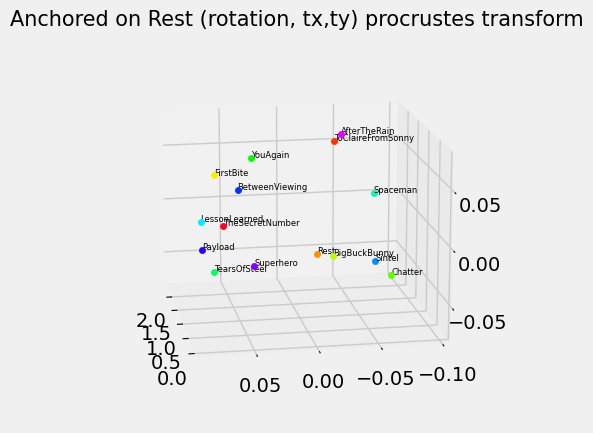

In [195]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle(color=[cm(1.*i/15) for i in range(15)])

for idx,mov in enumerate(labels):
    ax.scatter([features[idx,0]],
            [features[idx,1]],
            [features[idx,2]], linewidth=0.5, label=mov)
    ax.text(features[idx,0] , features[idx,1], features[idx,2], mov, None, size=6)
ax.view_init(15, 170)
ax.set_title('Anchored on Rest (rotation, tx,ty) procrustes transform', size=15)
# ax.legend(loc=4,prop={'size':5})

Text(0.5, 0.92, 'Anchored on Sintel (rotation, tx,ty) procrustes transform')

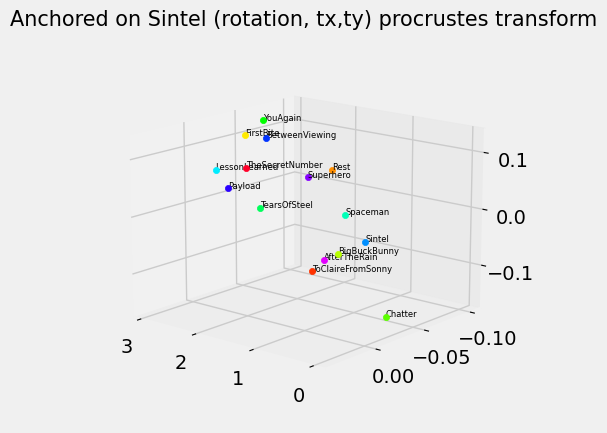

In [197]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle(color=[cm(1.*i/15) for i in range(15)])

for idx,mov in enumerate(labels):
    ax.scatter([features2[idx,0]],
            [features2[idx,1]],
            [features2[idx,2]], linewidth=0.5, label=mov)
    ax.text(features2[idx,0] , features2[idx,1], features2[idx,2], mov, None, size=6)
ax.view_init(15, 130)
ax.set_title('Anchored on {} (rotation, tx,ty) procrustes transform'.format(labels[10]), size=15)
# ax.legend(loc=4,prop={'size':5})

Using gradients and distance matrix to compute 2d embedding for order of films

In [111]:
twograds = np.asarray(grads)[:,:,[0,1]]
aff_mat  = np.zeros((len(twograds), len(twograds)))
for r,g1 in enumerate(twograds):
    for c,g2 in enumerate(twograds):
        dist = gradients_distance(g1,g2)
        aff_mat[r,c] = dist

aff_mat = 1 - aff_mat/(aff_mat.max())
## Perhaps add for stability
# np.random.seed(16)
# aff_mat += np.random.random((14,14))/50

Text(0.5, 1.0, 'ratio variance explained')

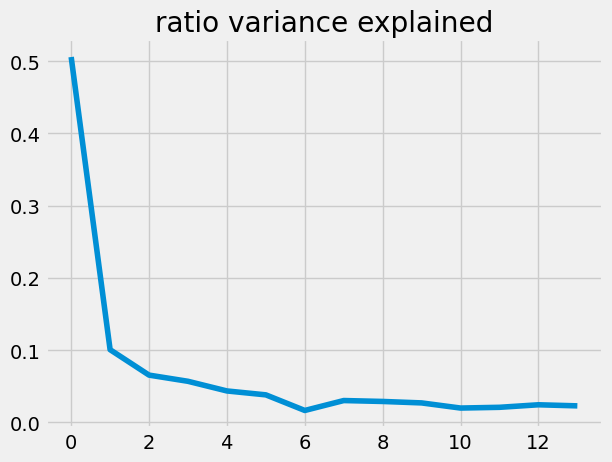

In [112]:
dstr, dspace = np.real(np.linalg.eig(aff_mat)[0]), np.real(np.linalg.eig(aff_mat)[1])
plt.plot(dstr/dstr.sum())
plt.title('ratio variance explained')

Text(0, 0.5, 'gradient2')

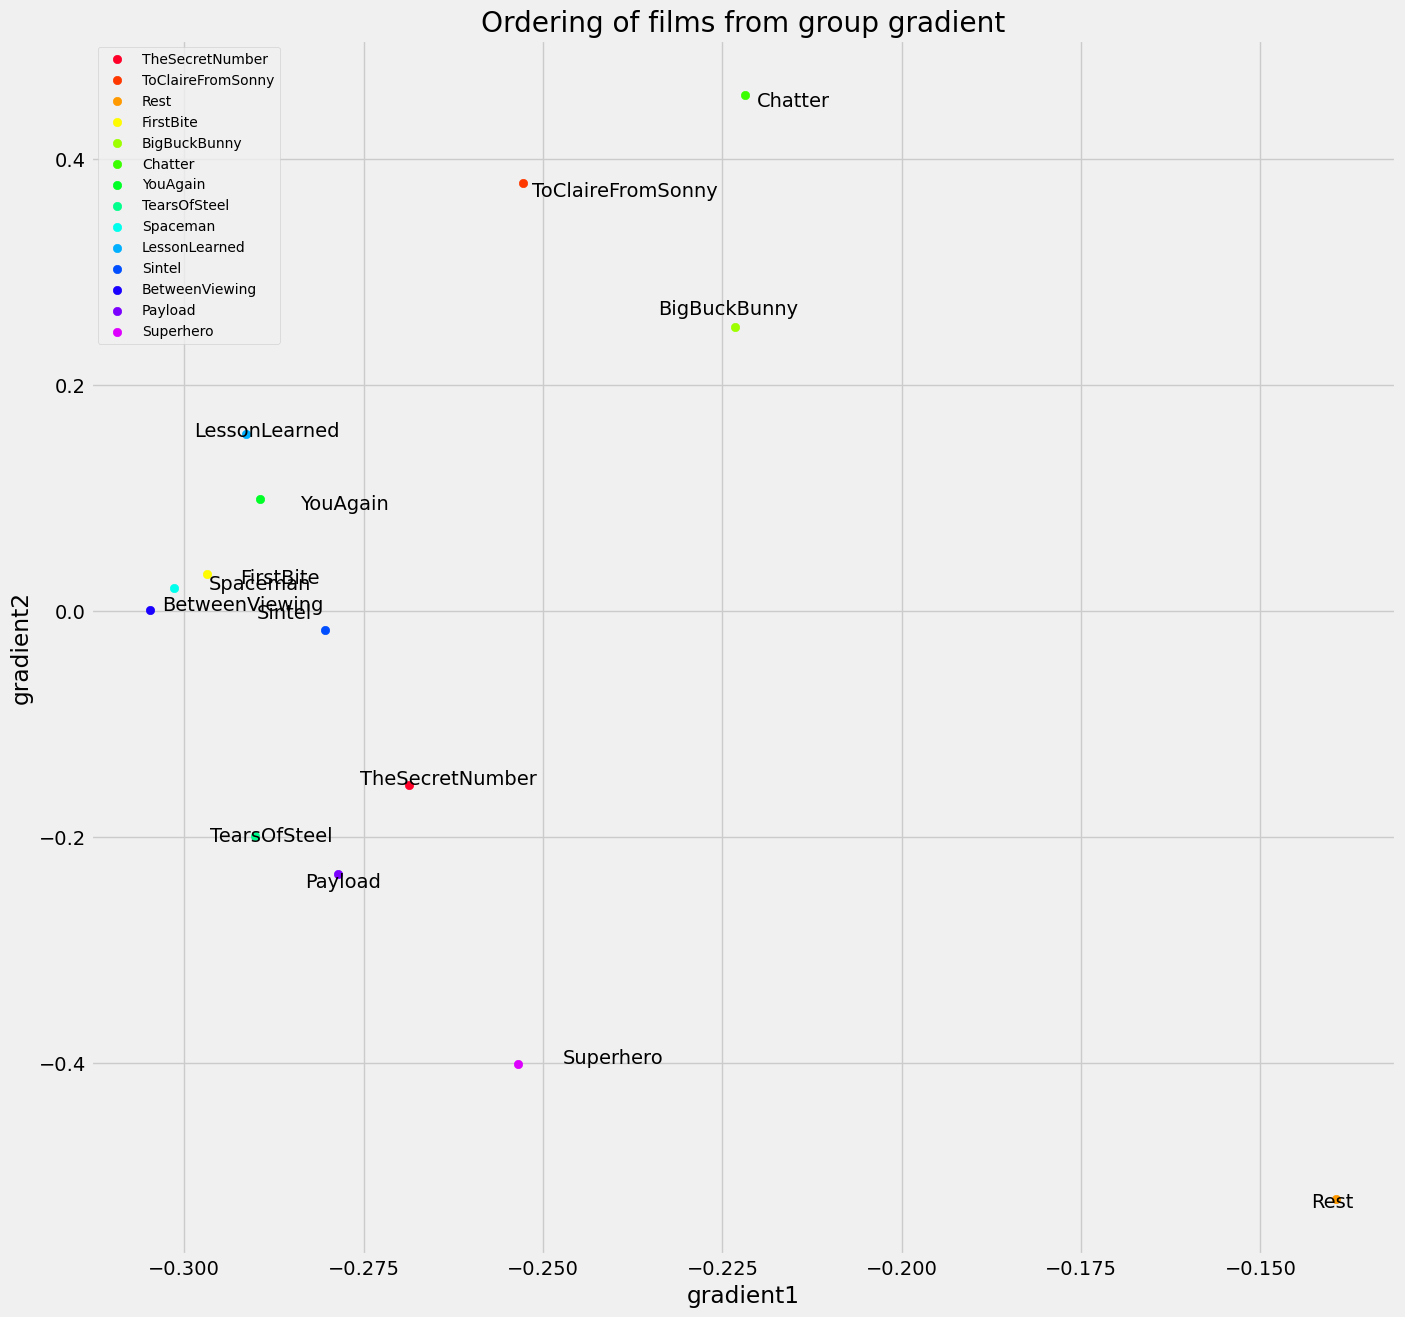

In [117]:
np.random.seed(16)
NUM_COLORS = len(dspace)

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
twograds = dspace[:,[0,1]]

for i, txt in enumerate(labels):
    ax.scatter([twograds[i][0]], [twograds[i][1]], label=txt)
    
    ax.annotate(txt, (twograds[i][0] + (np.random.random()-0.5) / 40,
                     twograds[i][1] + (np.random.random()-0.5) / 40 ) )

ax.set_title("Ordering of films from group gradient")
ax.legend(loc=2, prop={'size':10})
ax.set_xlabel("gradient1")
ax.set_ylabel("gradient2")

Subject level (quick check)

In [48]:
path  = './resources/static_grad/individual_level/'
grads2 = []
labels2 = []
for mov in os.listdir(path):
    grads2.append(load(path + mov))
    labels2.append(mov.split('_')[0])

In [50]:
from brainspace.gradient import procrustes_alignment

In [58]:
# aligning all objects
Gindi = []
encode = []
for i in range(len(labels2)):
    subj = grads2[i].keys()
    for s in subj:
        Gindi.append(grads2[i][s])
        encode.append(labels2[i]+'_'+s)

In [76]:
aligned,ref = procrustes_alignment(Gindi, return_reference=True, n_iter=100)

In [93]:
twograds = np.asarray(aligned)[:,:,[0,1]]
aff_mat2  = np.zeros((len(twograds), len(twograds)))
for r,g1 in enumerate(tqdm(twograds)):
    for c,g2 in enumerate(twograds):
        dist = gradients_distance(g1,g2)
        aff_mat2[r,c] = dist

aff_mat2 = 1 - aff_mat2/(aff_mat2.max())

100%|██████████| 420/420 [03:40<00:00,  1.91it/s]


(0.0, 10.0)

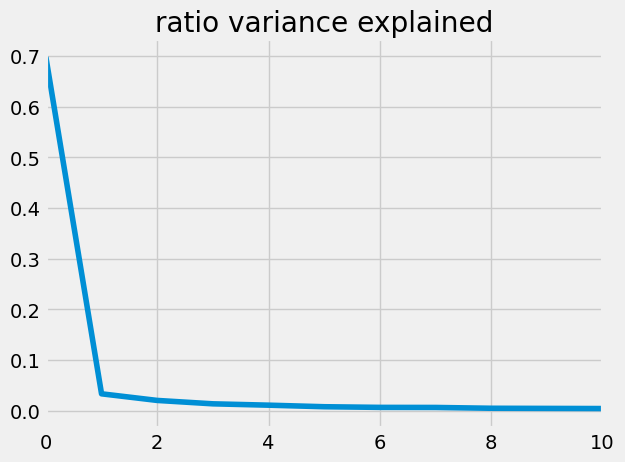

In [122]:
dstr, dspace = np.real(np.linalg.eig(aff_mat2)[0]), np.real(np.linalg.eig(aff_mat2)[1])
plt.plot(dstr/dstr.sum())
plt.title('ratio variance explained')
plt.xlim(0,10)

Text(0, 0.5, 'gradient2')

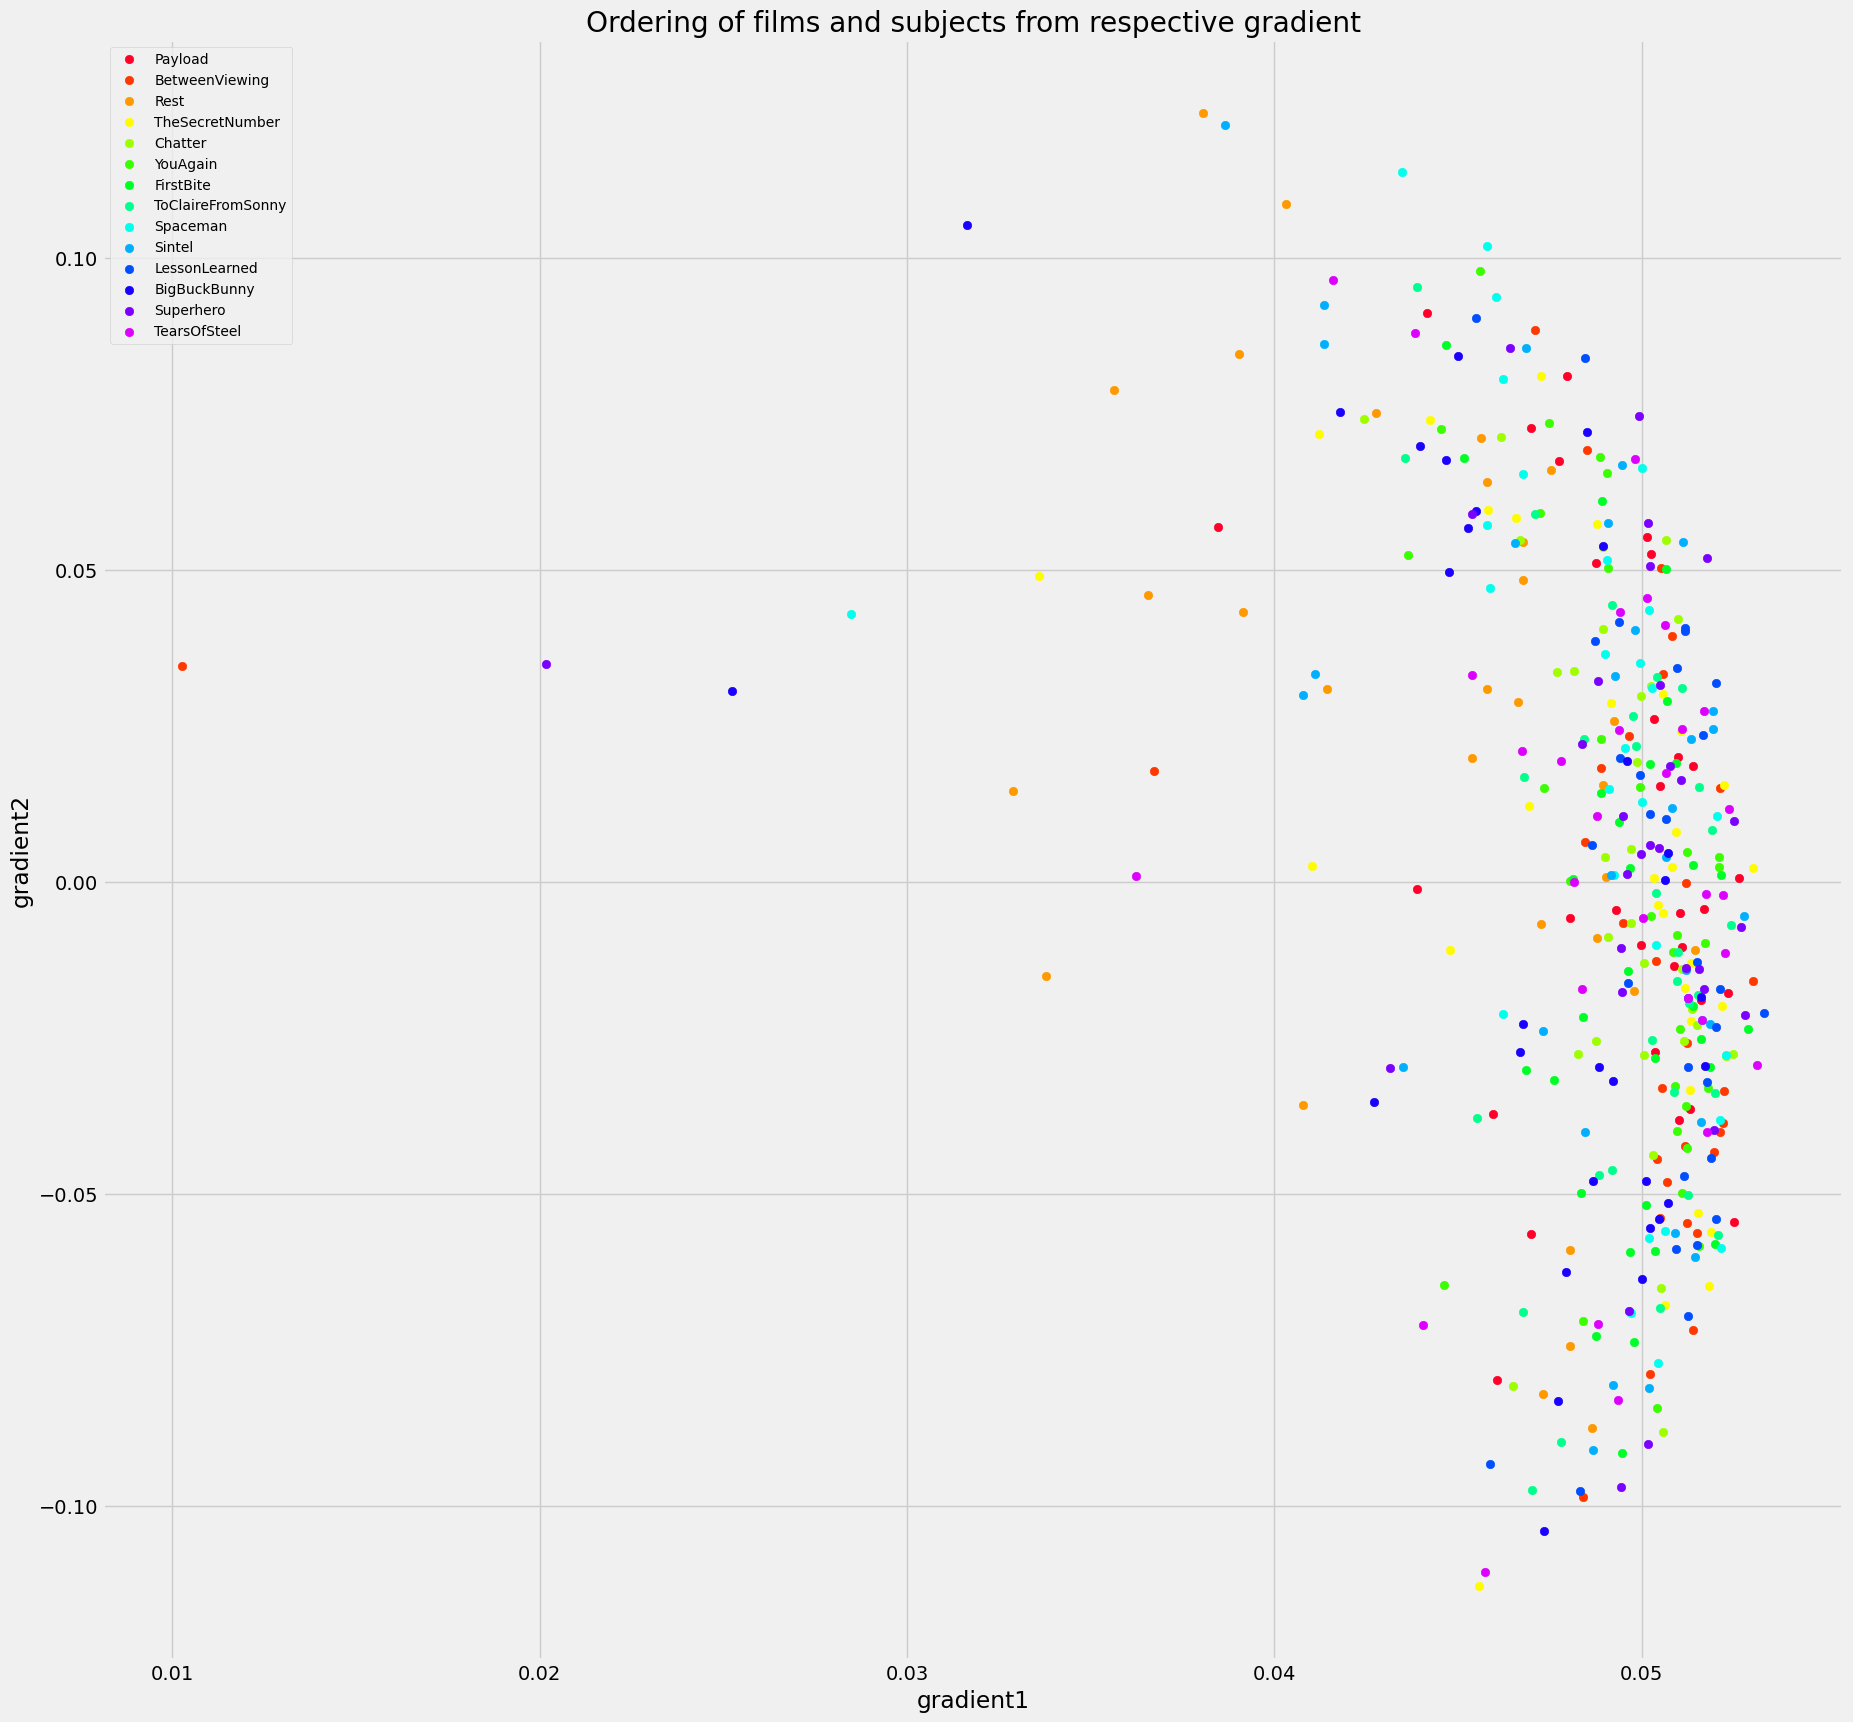

In [128]:
np.random.seed(16)
NUM_COLORS = len(labels2)

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ind_2_grads = dspace[:,[0,1]]

for i, txt in enumerate(labels2):
    # 30 being the number of subjects
    m = i * 30 
    ax.scatter(ind_2_grads[m:m+30,0], ind_2_grads[m:m+30,1], label=txt)
    
ax.set_title("Ordering of films and subjects from respective gradient")
ax.legend(loc=2, prop={'size':10})
ax.set_xlabel("gradient1")
ax.set_ylabel("gradient2")